### PCA on feature-specific conditions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
from utils.session_data import SessionData
import utils.io_utils as io_utils
from constants.behavioral_constants import *
import json

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

import matplotlib.pyplot as plt
import matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import plotly.express as px


In [2]:
# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"
# path to a dataframe of sessions to analyze
# SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
# path for each session, specifying behavior
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
# SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_residual_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 50  # size of interval in ms

In [3]:
FEATURE = "MAGENTA"
# FEATURE = "STAR"
# FEATURE = "CIRCLE"
# FEATURE = "TRIANGLE"
MIN_NUM_TRIALS = 20
CONDITIONS = ["MaxFeatMatches", "RPEGroup"]
# REGION = "hippocampal_formation (HF)"
# REGION = "orbital_frontal_cortex (OFC)"
# REGION = "all"

In [4]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
units = spike_utils.get_unit_positions(valid_sess)
# region_units = units[units.manual_structure == "Prefrontal Cortex"]
# region_units = units[units.manual_structure == "Anterior Cingulate Gyrus"]

# region_units = units[units.structure_level2 == REGION]
# region_units = units[units.structure_level3 == REGION]

region_units = units

In [5]:
units.manual_structure.unique()

array(['Claustrum', 'Prefrontal Cortex', 'Visual Cortex',
       'Anterior Cingulate Gyrus', 'Parietal Cortex', 'unknown',
       'Basal Ganglia', 'Hippocampus/MTL', 'Premotor Cortex', 'Amygdala'],
      dtype=object)

In [6]:
def validate_and_label_sessions(row, feature, region_units, shuffle=False, balance=True):
    # check region specificity:
    # if not row.session_name in region_units.session.values:
    #     return None
    labeled_beh = behavioral_utils.get_beh_model_labels_for_session_feat(row.session_name, feature)
    labeled_beh = labeled_beh[labeled_beh.Response == "Correct"]
    enough_trials = behavioral_utils.validate_enough_trials_by_condition(labeled_beh, CONDITIONS, MIN_NUM_TRIALS, num_unique_conditions=4)
    if not enough_trials:
        return None
    # TODO: determine whether or not this is needed: 
    if balance: 
        labeled_beh = behavioral_utils.balance_trials_by_condition(labeled_beh, CONDITIONS)
    # HACK: doesn't generalize to other conditions
    labeled_beh["Condition"] = labeled_beh.MaxFeatMatches.astype(str) + " " + labeled_beh.RPEGroup
    if shuffle: 
        rng = np.random.default_rng()
        vals = labeled_beh["Condition"].values
        rng.shuffle(vals)
        labeled_beh["Condition"] = vals
    frs_path = SESS_SPIKES_PATH.format(
        sess_name=row.session_name, 
        pre_interval=PRE_INTERVAL, 
        event=EVENT, 
        post_interval=POST_INTERVAL, 
        interval_size=INTERVAL_SIZE
    )
    frs = pd.read_pickle(frs_path)
    frs["PseudoUnitID"] = int(row.session_name) * 100 + frs["UnitID"]
    frs = frs[frs.PseudoUnitID.isin(region_units.PseudoUnitID)]
    merged = pd.merge(labeled_beh, frs, on="TrialNumber")
    if len(merged) == 0:
        return None
    return merged


In [7]:
def project_conditioned_firing_rates(all_trials):
    """
    Condition-average firing rates by Condition column,
    Calculate 1st 3 PCs of condition-averaged firing rates
    Return projected dataframe, PCA object
    """
    conditions = all_trials.Condition.unique()
    conditions.sort()
    conditioned_frs = all_trials.groupby(["Condition", "PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("ConditionedFiringRate").reset_index()

    conditioned_frs_sorted = conditioned_frs.sort_values(by=["PseudoUnitID", "Condition", "TimeBins"])
    num_units = len(conditioned_frs.PseudoUnitID.unique())
    num_conds = len(conditioned_frs.Condition.unique())
    num_time_bins = len(conditioned_frs.TimeBins.unique())
    data_mat = conditioned_frs_sorted.ConditionedFiringRate.values.reshape((num_units, num_conds * num_time_bins))

    pca = PCA()
    pca = pca.fit(data_mat.T)
    components = pca.components_

    def transform_pca(group):
        group = group.sort_values(by="PseudoUnitID")
        vec = group.ConditionedFiringRate.values.reshape(-1, 1)
        # print(vec.shape)
        # print(components.shape)
        transformed = components @ vec
        # print(transformed.shape)
        return pd.Series({"PC1": transformed[0, 0], "PC2": transformed[1, 0], "PC3": transformed[2, 0]})
    transformed_df = conditioned_frs_sorted.groupby(["TimeBins", "Condition"]).apply(transform_pca).reset_index()

    return transformed_df, pca

### Look at PCA for a single feature

In [8]:
res = valid_sess.apply(lambda x: validate_and_label_sessions(x, FEATURE, region_units, shuffle=False, balance=True), axis=1)
res = res.dropna()
all_trials = pd.concat(res.values)

In [28]:
# get only after feedback timepoints
all_trials = all_trials[all_trials.TimeBins > 1.3]

In [29]:
transformed_df, pca = project_conditioned_firing_rates(all_trials)

In [30]:
# see how many total trials there are per condition
all_trials["PseudoTrialNumber"] = (all_trials.Session.astype(str) + all_trials.TrialNumber.astype(str)).astype(int)
all_trials.groupby("Condition").PseudoTrialNumber.nunique()

Condition
False less pos    463
False more pos    463
True less pos     463
True more pos     463
Name: PseudoTrialNumber, dtype: int64

Text(0, 0.5, 'Cumulative variance explained')

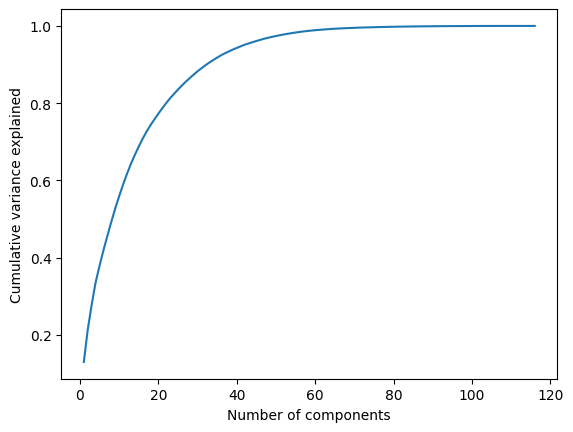

In [31]:
fig, ax = plt.subplots()
var_ratios = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(1, len(var_ratios) +1), var_ratios)
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative variance explained")

In [32]:
fig = px.scatter_3d(
    transformed_df, 
    x='PC1', y='PC2', z='PC3',
    color='Condition', 
    opacity=1,
    size='TimeBins',
    # color_discrete_sequence=colors
)
fig.show()


### Do it for two features at once, SQUARE and TRIANGLE

In [23]:
# FEATURE_1 = "SQUARE"
# FEATURE_2 = "TRIANGLE"
FEATURE_1 = "MAGENTA"
FEATURE_2 = "YELLOW"
feat_1_res = valid_sess.apply(lambda x: validate_and_label_sessions(x, FEATURE_1, region_units, shuffle=False, balance=True), axis=1)
feat_1_res = feat_1_res.dropna()
feat_2_res = valid_sess.apply(lambda x: validate_and_label_sessions(x, FEATURE_2, region_units, shuffle=False, balance=True), axis=1)
feat_2_res = feat_2_res.dropna()


In [10]:
print(feat_1_res[feat_1_res.index.isin(feat_2_res.index)].index)

Int64Index([15, 17, 39, 43, 44, 68, 74, 93, 97], dtype='int64')


In [24]:
feat_1_trials = pd.concat(feat_1_res[feat_1_res.index.isin(feat_2_res.index)].values)
feat_2_trials = pd.concat(feat_2_res[feat_2_res.index.isin(feat_1_res.index)].values)
feat_1_trials["Condition"] = FEATURE_1 + " " + feat_1_trials.Condition
feat_2_trials["Condition"] = FEATURE_2 + " " + feat_2_trials.Condition
all_trials = pd.concat((feat_1_trials, feat_2_trials))

In [25]:
all_trials = all_trials[all_trials.TimeBins > 1.3]

In [26]:
all_trials.Condition.unique()
true_conds = [FEATURE_1 + ' True less pos', FEATURE_1 + ' True more pos', FEATURE_2 + ' True less pos', FEATURE_2 + ' True more pos']
false_conds = [FEATURE_1 + ' False less pos', FEATURE_1 + ' False more pos', FEATURE_2 + ' False less pos', FEATURE_2 + ' False more pos']
true_trials = all_trials[all_trials.Condition.isin(true_conds)]
false_trials = all_trials[all_trials.Condition.isin(false_conds)]


In [27]:
all_trials["PseudoTrialNumber"] = (all_trials.Session.astype(str) + all_trials.TrialNumber.astype(str)).astype(int)
all_trials.groupby("Condition").PseudoUnitID.nunique()

Condition
MAGENTA False less pos    280
MAGENTA False more pos    280
MAGENTA True less pos     280
MAGENTA True more pos     280
YELLOW False less pos     280
YELLOW False more pos     280
YELLOW True less pos      280
YELLOW True more pos      280
Name: PseudoUnitID, dtype: int64

In [28]:
transformed_df, pca_true = project_conditioned_firing_rates(true_trials)
transformed_df["ZeroedTimeBins"] = transformed_df.TimeBins - 1.3

In [29]:
fig = px.scatter_3d(
    transformed_df, 
    x='PC1', y='PC2', z='PC3',
    color='Condition', 
    opacity=1,
    size='ZeroedTimeBins',
    # color_discrete_sequence=colors
)
fig.show()


In [30]:
transformed_df, pca_false = project_conditioned_firing_rates(false_trials)
transformed_df["ZeroedTimeBins"] = transformed_df.TimeBins - 1.3
fig = px.scatter_3d(
    transformed_df, 
    x='PC1', y='PC2', z='PC3',
    color='Condition', 
    opacity=1,
    size='ZeroedTimeBins',
    # color_discrete_sequence=colors
)
fig.show()

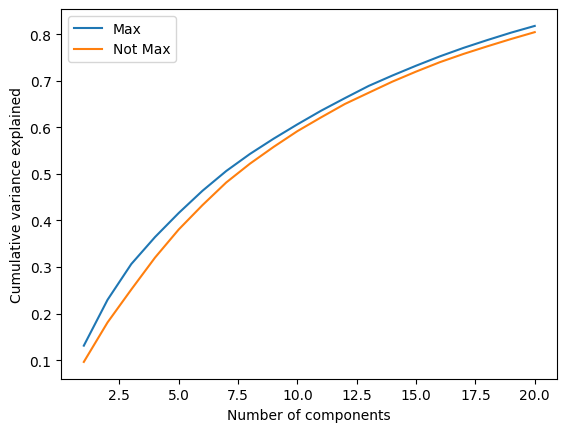

In [22]:
fig, ax = plt.subplots()
true_var_ratios = np.cumsum(pca_true.explained_variance_ratio_[:20])
false_var_ratios = np.cumsum(pca_false.explained_variance_ratio_[:20])
ax.plot(np.arange(1, len(true_var_ratios) +1), true_var_ratios, label="Max")
ax.plot(np.arange(1, len(false_var_ratios) +1), false_var_ratios, label="Not Max")

ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative variance explained")
ax.legend()